In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Button
from scipy.linalg import pinv
from matplotlib.animation import FuncAnimation


In [2]:
class UR5Simulator:
    def __init__(self):
        self.dh_params = np.array([
            [0, 0.0892, 0, np.pi/2],
            [0, 0, -0.425, 0],
            [0, 0, -0.39225, 0],
            [0, 0.1093, 0, np.pi/2],
            [0, 0.09475, 0, -np.pi/2],
            [0, 0.0823, 0, 0]
        ])
        self.initial_guess = np.array([0,-np.pi/2, 0, 0, np.pi/2, 0])
        self.fig, self.ax = plt.subplots(subplot_kw={'projection': '3d'})
        self.buttons = []  
        self.end_effector_trace = []
        self.plot_robot(self.initial_guess)
        self.setup_buttons()


    def dh_matrix(self, theta, d, a, alpha):
        ct, st = np.cos(theta), np.sin(theta)
        ca, sa = np.cos(alpha), np.sin(alpha)
        return np.array([
            [ct, -st * ca, st * sa, a * ct],
            [st, ct * ca, -ct * sa, a * st],
            [0, sa, ca, d],
            [0, 0, 0, 1]
        ])

    def forward_kinematics(self, joints):
        T = np.eye(4)
        for i in range(len(joints)):
            theta = joints[i] + self.dh_params[i, 0]
            d = self.dh_params[i, 1]
            a = self.dh_params[i, 2]
            alpha = self.dh_params[i, 3]
            T_i = self.dh_matrix(theta, d, a, alpha)
            T = np.dot(T, T_i)
        return T[:3, 3]

    def plot_robot(self, joints):
        T = np.eye(4)
        positions = [np.array([0, 0, 0])]
        self.ax.clear()

        self.plot_axes(np.eye(4), scale=0.1)

        for i in range(len(joints)):
            theta = joints[i] + self.dh_params[i, 0]
            d = self.dh_params[i, 1]
            a = self.dh_params[i, 2]
            alpha = self.dh_params[i, 3]
            T_i = self.dh_matrix(theta, d, a, alpha)
            T = np.dot(T, T_i)
            positions.append(T[:3, 3])

        self.end_effector_trace.append(positions[-1])
        trace_array = np.array(self.end_effector_trace)

        positions = np.array(positions)
        self.ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], '-o', color='gray', markerfacecolor='skyblue', markersize=8, linewidth=2)
        
        self.plot_axes(T, scale=0.1)

        if len(trace_array) > 1:
            self.ax.plot(trace_array[:, 0], trace_array[:, 1], trace_array[:, 2], 'r-', linewidth=1)  # Plotting the trace as a red line

        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        self.ax.set_zlabel('Z')
        self.ax.set_xlim([-1, 1])
        self.ax.set_ylim([-1, 1])
        self.ax.set_zlim([0, 1.5])
        plt.draw()

    def plot_axes(self, T, scale=0.05):
        """Helper function to draw RGB axes at a given transformation matrix T"""
        colors = ['r', 'g', 'b']
        for i in range(3):
            start = T[:3, 3]
            end = start + T[:3, i] * scale
            self.ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], color=colors[i], linewidth=2)

    def update_position(self, direction):
        step_size = 0.05
        movement = {'X+': [step_size, 0, 0], 'X-': [-step_size, 0, 0],
                    'Y+': [0, step_size, 0], 'Y-': [0, -step_size, 0],
                    'Z+': [0, 0, step_size], 'Z-': [0, 0, -step_size]}
        new_position = self.forward_kinematics(self.initial_guess)[-1] + np.array(movement[direction])
        self.initial_guess = self.inverse_kinematics(new_position, self.initial_guess)
        self.plot_robot(self.initial_guess)

    def inverse_kinematics(self, target, initial_guess):
        joints = np.array(initial_guess)
        tolerance = 1e-3  
        for _ in range(1000):
            current_pos = self.forward_kinematics(joints)
            error = target - current_pos[:3]
            if np.linalg.norm(error) < tolerance:
                break
            J = np.zeros((3, len(joints)))
            for i in range(len(joints)):
                perturbed_joints = np.copy(joints)
                perturbed_joints[i] += 1e-6
                perturbed_pos = self.forward_kinematics(perturbed_joints)
                J[:, i] = (perturbed_pos[:3] - current_pos[:3]) / 1e-6
            joints += pinv(J) @ error
        return joints


    def setup_buttons(self):
        directions = ['X+', 'X-', 'Y+', 'Y-', 'Z+', 'Z-']
        button_callbacks = {
            'X+': lambda event: self.update_position('X+'),
            'X-': lambda event: self.update_position('X-'),
            'Y+': lambda event: self.update_position('Y+'),
            'Y-': lambda event: self.update_position('Y-'),
            'Z+': lambda event: self.update_position('Z+'),
            'Z-': lambda event: self.update_position('Z-')
        }
        for i, direction in enumerate(directions):
            ax_button = plt.axes([0.81, 0.05 + 0.065 * i, 0.1, 0.05])
            button = Button(ax_button, direction)
            button.on_clicked(button_callbacks[direction])
            self.buttons.append(button)



    def square_motion(self, start_pos=np.array([0.3, 0.3, 0]), side_length=0.2, increment=0.001):
        num_points_per_side = int(side_length / increment)
        points = []
        # Bottom side
        for i in range(num_points_per_side + 1):
            points.append(start_pos + np.array([i * increment, 0, 0]))
        # Right side
        for i in range(num_points_per_side + 1):
            points.append(start_pos + np.array([side_length, i * increment, 0]))
        # Top side
        for i in range(num_points_per_side + 1):
            points.append(start_pos + np.array([side_length - i * increment, side_length, 0]))
        # Left side
        for i in range(num_points_per_side + 1):
            points.append(start_pos + np.array([0, side_length - i * increment, 0]))
        return np.array(points)

    def animate_path(self, path):
        def update(frame):
            # Assuming 'frame' is a position, find joints using inverse kinematics
            if len(self.initial_guess) == 0:
                self.initial_guess = np.array([0, -np.pi/2, 0, 0, np.pi/2, 0])  # Default guess if not set
            joints = self.inverse_kinematics(frame, self.initial_guess)
            self.plot_robot(joints)
            self.initial_guess = joints  # Update the initial guess for the next frame

        anim = FuncAnimation(self.fig, update, frames=path, interval=100)
        plt.show()


    def show(self):
        plt.show()

    def run(self, square=True):
        if square:
            start_pos = np.array([0.2, 0.2, 0.1])  
            path = self.square_motion(start_pos, side_length=0.2, increment=0.001)
            self.animate_path(path)
        else:
            self.show()

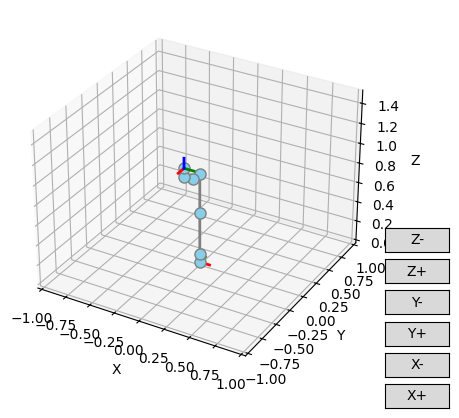

In [3]:
if __name__ == '__main__':
    simulator = UR5Simulator()
    user_choice = input("Would you like to run the square trajectory? (yes/no): ").strip().lower()
    if user_choice == 'yes':
        simulator.run(square=True)
    else:
        simulator.run(square=False)

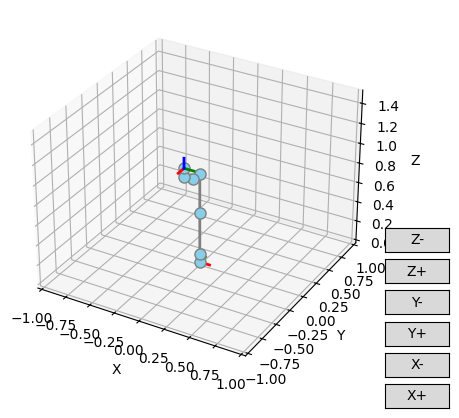

In [4]:
if __name__ == '__main__':
    simulator = UR5Simulator()
    user_choice = input("Would you like to run the square trajectory? (yes/no): ").strip().lower()
    if user_choice == 'yes':
        simulator.run(square=True)
    else:
        simulator.run(square=False)

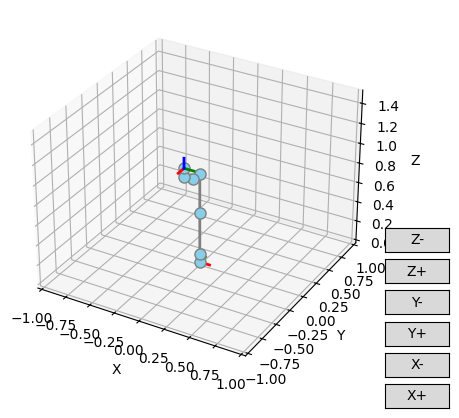

In [6]:
if __name__ == '__main__':
    simulator = UR5Simulator()

In [9]:
# DH parameters of UR5 Arm
simulator.dh_params 

array([[ 0.        ,  0.0892    ,  0.        ,  1.57079633],
       [ 0.        ,  0.        , -0.425     ,  0.        ],
       [ 0.        ,  0.        , -0.39225   ,  0.        ],
       [ 0.        ,  0.1093    ,  0.        ,  1.57079633],
       [ 0.        ,  0.09475   ,  0.        , -1.57079633],
       [ 0.        ,  0.0823    ,  0.        ,  0.        ]])

In [10]:
# Initial guess ..
simulator.initial_guess

array([ 0.        , -1.57079633,  0.        ,  0.        ,  1.57079633,
        0.        ])